# Basic Clustering in Machine Learning: 
#### K-means, K-means++ and Spectral Clustering

In [219]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering


from kmeans import * 

This report explores some basics of clustering in machine learning, including K-means, K-means++ and Spectral Clustering. The goal is to explain how these algorithms work in detail, compare performance and applications on data of different nature.

The breast cancer Wisconsin dataset is used for algorithm comparison and visual context throughout. Features of this dataset describe characteristics of each patient's cell nucleus computed from image data. The target is a binary class, benign or malignant (noncancerous or cancerous). Even though clustering is an unsupervised machine learning algorithm; this dataset contains labeled data for visual support and enhanced understanding of the clustering approaches' performance and advantages/disadvantages. 

More specifically, an overview of what the report will cover is as follows: 

## Table of content:
* [Context](#first-bullet)
* [Basic Explanation of K-means](#second-bullet)
* [Using K-means for identifying breast cancer](#second-bullet)
* [Disadvantages of K-means](#second-bullet)
* [Basic Explanation of K-means++](#second-bullet)
* [Using K-means++ for compressing images](#second-bullet)
* [Using Spectral clustering for identifying breast cancer](#second-bullet)
* [References](#second-bullet)

# 1. Context:

Clustering is an Unsupervised Machine Learning (UML) technique that helps us organize objects into similar groups, also called clusters. It is different from Classification in Supervised Machine Learning (SML) as the objects are unlabeled. Object similarity is measured using a similarity or distance measure like Euclidean distance in the case of K-means. Therefore, a cluster is a group of similar objects. The similarity between them also called the intra-cluster distance, is smaller than the intercluster distance - the distance to objects belonging to another cluster.

# 2. K-Means

K-means is a popular centroid-based clustering algorithm and a natural starting point for discussion. As inferred by the name *K-means*, the algorithm partitions the observations into K clusters (non-overlapping sub-groups). Here, K represents the number of clusters we are trying to identify. Each cluster has an associated centroid, also called mean - the data point at the center of each cluster. The observations in our dataset are assigned to each centroid based on the pairwise Euclidean distances between points. 

The algorithm works as follows:
1. Initialize k centroids randomly
2. Assign each observation in our dataset to the closest centroid.
3. Update centroids coordinate with the mean coordinate of the assigned observation
4. Repeat step two and three until we reach the max number of iterations, or our centroids stabilize

For the detailed implementation of the K-means and K-means++ algorithm, please refer to my GitHub repository. 

# 3. K-means on Breast Cancer Dataset

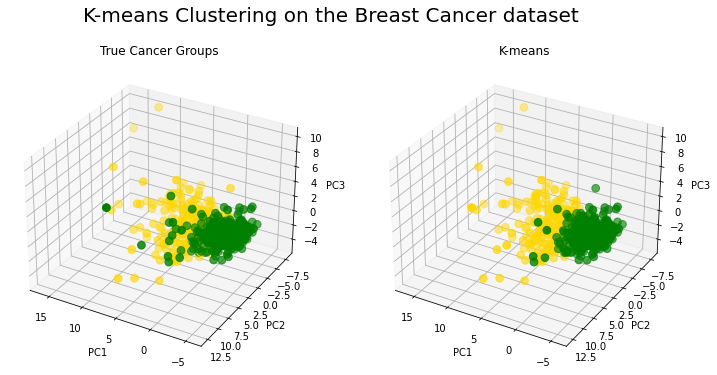

In [229]:
cancer = load_breast_cancer()
y = cancer.target
df = pd.DataFrame(np.c_[cancer['data'], cancer['target']],
                  columns=np.append(cancer['feature_names'], ['target']))
X = df.drop(['target'], axis=1)
scaler = StandardScaler().fit(X)
scaled_data = scaler.transform(X)
pca = PCA(n_components=3)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

# cluster groups using kmeans
centroids, labels = kmeans(scaled_data, 2)

# plotting the results
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

colors = np.array(['gold', 'green'])
ax1.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=colors[y], s=60)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.view_init(30, 120)

colors = np.array(['green', 'gold'])
ax2.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=colors[labels], s=60)
plt.suptitle('K-means Clustering on the Breast Cancer dataset', fontsize=20)
ax1.title.set_text('True Cancer Groups')
ax2.title.set_text('K-means')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.view_init(30, 120)

Above, I use Principal Component Analysis (PCA) to visualize how K-means is clustering instances of benign or malignant cancers. We see by the confusion matrix below that 50 instances were assigned to the incorrect cluster. 

In [230]:
confusion_matrix(y, labels)

array([[ 37, 175],
       [344,  13]])

# 4.  Disadvantages of K-means

**Cluster Initialization Problem:** The resulting clusters are sensitive to the random initialization of centroids. Here are two different outcomes of the k-means algorithm. The second outcome cannot find the natural cluster since the two centroids were both initialized within the same cluster. 

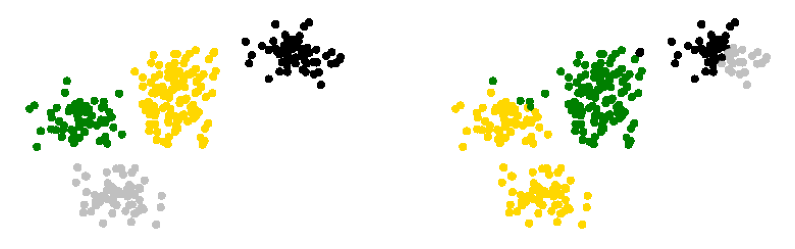

In [32]:
display_2_images('kmeans1.png', 'kmeans2.png')

<br>**Choosing K:**
<br> Because clustering is a UML algorithm, there is no ground truth to verify results. Neither do we know many groups are contained within our dataset. So how do we determine the optimal value for k? The Elbow Method is a very popular technique to find the optimal number of clusters. The method calculates loss as the intra-cluster sum of squared distances.

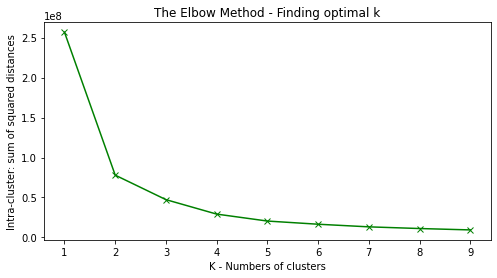

In [232]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(8,4))
plt.plot(K, distortions, 'bx-', color='green')
plt.xlabel('K - Numbers of clusters')
plt.ylabel('Intra-cluster: sum of squared distances')
plt.title('The Elbow Method - Finding optimal k', fontsize=12)
plt.show()

<br>**Assumes Euclidean space:**
<br>The similarity measure for K-means is euclidean distance. This is not the optimal similarity measure for all applications, especially when straight lines cannot separate clusters like we see below:

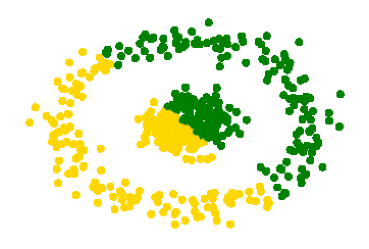

In [169]:
display_image('kmeans3.png')

<br>**Curse of dimensionality**
<br> When partitioning a high dimensional features space, the distance-based similarity measure quickly converges to a constant value. Thus K-means does not perform well on high-dimensional data unless reduced through PCA or spectral clustering, which we will discuss in detail in its assigned section.

# 5. K-means++

K-Means++ is a clever centroid initialization technique that avoids the Cluster Initialization Problem resulting from randomly allocating cluster centers in the standard K-means algorithm. Instead of picking k centroids at random, the Kmeans++ algorithm selects the first centroid at random and then computes the distance of all points from the chosen centroids. Then we select our new centroid to be the point further away from our old centroid. This minimizes the chances of centroids accidentally being initialized in the same cluster and provides better and more stable performance. 

K-means++ algorithm then works as follows:
1. Initialize the first centroid randomly
2. Initialize the following k-1 points by calculating the minimum distance to all existing clusters and then finds the centroid - the max distance amongst these minimum distances.
3. Repeat step two until allocating all k centroids 
4. Assign each observation in our dataset to the closest centroid.
5. Update centroids coordinate with the mean coordinate of the assigned observation
6. Repeat step three and four until we reach the max number of iterations, or our centroids stabilize

While K-means can identify different clusters for the breast cancer dataset every time we run the algorithm, the K-means++ algorithm identifies consistent clusters. All over, we see that the initialization has a significant impact on performance. 

# 6. Image Compression with K-means++

The k-means algorithm has many useful applications to image data and compression. One of them is image compression, as seen below. 

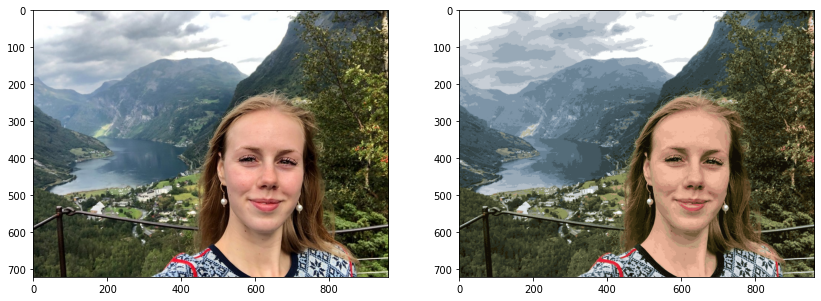

In [5]:
kmeans_image_compression('me.jpeg', 36)

The image on the right uses the K-means++ clustering technique to compress the original image using the pixel values. Compared to the original RGB image on the left, where each pixel requires 3 bytes, the right image only has 36 unique colors. With k-means color quantization, we can now store the mapping in these 36 colors to our image in which each pixel, we reduce each pixel by 3x.

# 7. Spectral clustering

One disadvantage of the k-means and the k-means++ algorithm is that it suffers from the Curse of Dimensionality. 
In spectral clustering, our data is treated as a graph partitioning problem, in which we do similarity computation and PCA that avoids this curse resulting from high-dimensionality distance measures. 

Steps in Spectral clustering : 
1. Compute a similarity graph
2. PCA 
3. Cluster the data in new low-dimensional space

Spectral clustering is, as we see, more a pre-clustering step than a separate clustering algorithm. 

A critical difference between K-Means Clustering and Spectral clustering is that K-means assume that the points are spherical close to the cluster, as we see on the left-hand cluster below.
However, in spectral clustering, there are no assumptions about the underlying form of the clusters. 

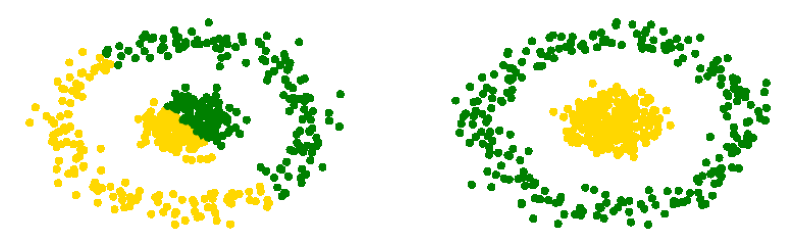

In [215]:
display_2_images('kmeans3.png', 'spectral_clustering.png')

# 8. Spectral Clustering on Breast Cancer Dataset

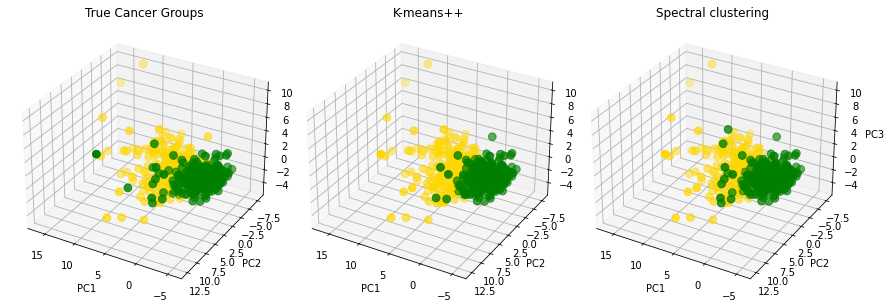

In [227]:
from kmeans import * 
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

colors=np.array(['gold','green'])
ax1.scatter(x_pca[:,0], x_pca[:,1], x_pca[:,2], c=colors[y], s=60)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.view_init(30, 120)

centroids, labels = kmeans(scaled_data, 2,  centroids = 'kmeans++')
ax2.scatter(x_pca[:,0], x_pca[:,1], x_pca[:,2], c=colors[labels], s=60)
ax1.title.set_text('True Cancer Groups')
ax2.title.set_text('K-means++')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.view_init(30, 120)

cluster = SpectralClustering(n_clusters=2, affinity="nearest_neighbors")
spectral_labels = cluster.fit_predict(scaled_data)
ax3.scatter(x_pca[:,0], x_pca[:,1], x_pca[:,2], c=colors[spectral_labels], s=60)

ax3.title.set_text('Spectral clustering')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')
ax3.view_init(30, 120)
plt.tight_layout()

The above visualization compares the performance of the k-means and spectral clustering (using the K-Nearest Neighbor as a similarity measure). Not surprisingly, spectral clustering captures true positive points further away from the spherical cluster than the K-means algorithm, with only 36 incorrect cluster instances (seen in the confusion matrix below).

In [222]:
confusion_matrix(y, spectral_labels)

array([[182,  30],
       [  6, 351]])

# 9. References: 

- https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages#:~:text=Curse%20of%20Dimensionality%20and%20Spectral,effective%20at%20distinguishing%20between%20examples.
- https://people.csail.mit.edu/dsontag/courses/ml14/notes/Luxburg07_tutorial_spectral_clustering.pdf